<a href="https://colab.research.google.com/github/YaleGu/DSSS_final/blob/main/DSSS_final_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series analysis of London crime data -- similarity between boroughs and prediction
      
### Student Number:20041295

## 1. Introduction
Data is obtained from the London Datastore (Mayor of London). This dataset records the number of crimes of each category monthly in London from 2008-2018 (borough level).

In this paper, we will first perform K-means clustering after calculating the similarity between the time series of total crime cases in each borough using Dynamic Time Warping (DTW), and then to see if the clustering results are spatially correlated from the map. Next, crime types are used as features for hierarchical clustering. Finally, Artificial Neural Networks (ANN) and recurrent neural networks (RNN) are applied to predict the change in total crime cases in London over time.

## 2 Research question
1) Which boroughs share similar temporal characteristics of crime cases and are they spatially correlated?

2) Which boroughs have a similar composition of cases of different crime types and are they spatially aggregated?

3) Which has better results, ANN or LSTM for crime case prediction?

## 3 Methodology
DTW
Unsupervised Learning
Deep Learning

## 4 Analysis


### Data Overview and Preprocessing
First we import the packages we need for the analysis.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

!pip install tslearn
import math
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM


In [68]:
# import data set

url = 'https://raw.githubusercontent.com/YaleGu/DSSS_final/main/MPS_Borough_Level_Crime_Historic.csv'
df= pd.read_csv(url)
df.head(5)

,Borough,Major Category,Minor Category,200801,200802,200803,200804,200805,200806,200807,200808,200809,200810,200811,200812,200901,200902,200903,200904,200905,200906,200907,200908,200909,200910,200911,200912,201001,201002,201003,201004,201005,201006,201007,201008,201009,201010,201011,201012,201101,...,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
0,Barking and Dagenham,Burglary,Burglary in a Dwelling,82,71,87,74,74,103,113,96,95,107,120,148,180,149,155,112,135,119,149,124,159,180,184,157,169,161,123,118,102,124,137,153,136,116,140,105,165,...,77,105,111,119,103,86,73,47,77,63,55,54,49,60,73,100,118,124,93,101,129,71,95,83,81,122,88,124,143,134,122,75,93,77,94,84,99,94,106,163
1,Barking and Dagenham,Burglary,Burglary in Other Buildings,59,68,56,53,57,39,44,37,52,65,52,67,51,67,64,80,69,51,56,49,58,39,51,55,53,47,49,49,58,59,47,46,51,52,62,49,50,...,50,34,36,32,44,53,32,42,42,47,32,33,45,40,24,19,40,78,67,53,68,57,72,47,42,47,53,49,67,48,61,65,39,52,40,36,50,61,60,50
2,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,79,52,55,73,63,80,73,75,59,68,71,55,70,74,56,61,65,69,62,59,58,44,56,48,50,67,39,63,58,55,67,65,39,59,51,48,59,...,28,28,36,38,36,39,50,36,58,30,48,38,31,29,32,26,28,31,36,31,32,46,48,49,28,35,32,28,34,23,30,29,32,29,21,29,23,35,21,15
3,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,142,138,118,158,126,96,116,123,103,102,106,111,115,107,173,134,151,97,103,80,72,88,92,66,95,69,114,97,81,114,80,78,80,93,80,56,71,...,68,65,80,105,75,83,73,61,81,73,69,68,61,69,67,59,65,62,61,61,71,59,66,77,72,63,48,57,60,51,53,64,64,67,69,42,38,42,47,33
4,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,20,19,20,23,16,12,17,18,14,14,14,9,22,21,16,24,19,12,9,21,7,15,12,12,12,18,13,17,16,14,27,16,10,12,21,9,14,...,10,9,16,10,13,10,21,13,13,18,15,16,11,12,16,8,10,6,13,9,7,12,6,8,7,12,11,10,10,5,6,9,8,8,7,7,11,5,4,7


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Columns: 135 entries, Borough to 201812
dtypes: int64(132), object(3)
memory usage: 1.1+ MB


In [70]:
df.isnull().sum(axis=0).sort_values(ascending=False)

201812     0
201111     0
201009     0
201010     0
201011     0
          ..
201509     0
201510     0
201511     0
201512     0
Borough    0
Length: 135, dtype: int64

In [71]:
df['Borough'].unique()

array(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney',
       'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'],
      dtype=object)

In [72]:
df['Major Category'].unique()

array(['Burglary', 'Criminal Damage', 'Drugs', 'Fraud or Forgery',
       'Other Notifiable Offences', 'Robbery', 'Sexual Offences',
       'Theft and Handling', 'Violence Against the Person'], dtype=object)

### 4.1 Time series clustering

In [73]:
df1 = df.drop(['Major Category','Minor Category'],axis=1)
df1 = df1.groupby('Borough').sum()
df1 = df1.T
df1

Borough,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith and Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington and Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
200801,1686,2206,1396,2280,2190,2731,2730,2889,2332,2697,2502,1975,2432,1158,1555,2315,1997,2349,1838,968,2896,2673,1171,3175,1981,979,3459,1154,2425,2099,2299,5027
200802,1636,1939,1344,2062,2087,2696,2475,2855,2150,2384,2385,1838,2332,1143,1531,2171,2034,2571,1696,949,2914,2586,1215,2709,1870,996,3325,1032,2359,2037,2208,5033
200803,1599,2196,1454,2280,2153,2874,2614,2617,2163,2624,2580,1760,2427,1219,1449,2224,2011,2484,1913,1066,2868,2509,1247,2937,2078,984,3323,1145,2518,2123,2249,5251
200804,1732,2195,1363,2044,2106,2737,2444,2608,2245,2429,2505,1885,2352,1254,1631,1904,1964,2372,1865,951,2828,2484,1233,2704,2128,942,3343,1133,2640,2145,2186,5042
200805,1625,2374,1354,2315,2232,2871,2745,2856,2179,2660,2697,1882,2341,1255,1543,1925,2015,2350,1936,1025,2971,2897,1300,3015,2032,967,3557,1234,2584,2321,2189,5102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201808,1457,2244,1243,2503,1850,2853,2571,2265,2278,2086,2620,1794,2474,1140,1519,2199,1924,2281,2327,1125,2906,2153,1143,2967,1756,1085,3063,999,2890,1964,2040,5452
201809,1456,2261,1261,2545,1937,2883,2507,2412,2279,2231,2676,1929,2497,1233,1517,2233,2015,2362,1781,1024,2781,2127,1101,2932,1901,1011,2959,965,2838,2028,2100,4977
201810,1578,2545,1336,2708,1968,3045,2795,2544,2434,2268,2871,1952,2530,1389,1603,2505,2363,2614,1792,1186,2895,2373,1232,3118,2084,1148,3223,1056,2917,2178,2153,5578
201811,1540,2560,1395,2720,1985,3124,2624,2590,2485,2223,2874,1899,2686,1402,1665,2631,2245,2355,1889,1115,3028,2239,1214,3134,2108,1199,3143,1017,2884,2076,2148,6052


In [74]:
df1.insert(loc=0, column='Date', value=df1.index)

In [75]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 200801 to 201812
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Date                    132 non-null    object
 1   Barking and Dagenham    132 non-null    int64 
 2   Barnet                  132 non-null    int64 
 3   Bexley                  132 non-null    int64 
 4   Brent                   132 non-null    int64 
 5   Bromley                 132 non-null    int64 
 6   Camden                  132 non-null    int64 
 7   Croydon                 132 non-null    int64 
 8   Ealing                  132 non-null    int64 
 9   Enfield                 132 non-null    int64 
 10  Greenwich               132 non-null    int64 
 11  Hackney                 132 non-null    int64 
 12  Hammersmith and Fulham  132 non-null    int64 
 13  Haringey                132 non-null    int64 
 14  Harrow                  132 non-null    int64 
 15  Hav

In [76]:
df1['DateTime'] = df1['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m'))
df1.head(5)

Borough,Date,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith and Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington and Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,DateTime
200801,200801,1686,2206,1396,2280,2190,2731,2730,2889,2332,2697,2502,1975,2432,1158,1555,2315,1997,2349,1838,968,2896,2673,1171,3175,1981,979,3459,1154,2425,2099,2299,5027,2008-01-01
200802,200802,1636,1939,1344,2062,2087,2696,2475,2855,2150,2384,2385,1838,2332,1143,1531,2171,2034,2571,1696,949,2914,2586,1215,2709,1870,996,3325,1032,2359,2037,2208,5033,2008-02-01
200803,200803,1599,2196,1454,2280,2153,2874,2614,2617,2163,2624,2580,1760,2427,1219,1449,2224,2011,2484,1913,1066,2868,2509,1247,2937,2078,984,3323,1145,2518,2123,2249,5251,2008-03-01
200804,200804,1732,2195,1363,2044,2106,2737,2444,2608,2245,2429,2505,1885,2352,1254,1631,1904,1964,2372,1865,951,2828,2484,1233,2704,2128,942,3343,1133,2640,2145,2186,5042,2008-04-01
200805,200805,1625,2374,1354,2315,2232,2871,2745,2856,2179,2660,2697,1882,2341,1255,1543,1925,2015,2350,1936,1025,2971,2897,1300,3015,2032,967,3557,1234,2584,2321,2189,5102,2008-05-01


In [77]:
df1 = df1.set_index(['DateTime'], drop=True)
df1

Borough,Date,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith and Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington and Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-01,200801,1686,2206,1396,2280,2190,2731,2730,2889,2332,2697,2502,1975,2432,1158,1555,2315,1997,2349,1838,968,2896,2673,1171,3175,1981,979,3459,1154,2425,2099,2299,5027
2008-02-01,200802,1636,1939,1344,2062,2087,2696,2475,2855,2150,2384,2385,1838,2332,1143,1531,2171,2034,2571,1696,949,2914,2586,1215,2709,1870,996,3325,1032,2359,2037,2208,5033
2008-03-01,200803,1599,2196,1454,2280,2153,2874,2614,2617,2163,2624,2580,1760,2427,1219,1449,2224,2011,2484,1913,1066,2868,2509,1247,2937,2078,984,3323,1145,2518,2123,2249,5251
2008-04-01,200804,1732,2195,1363,2044,2106,2737,2444,2608,2245,2429,2505,1885,2352,1254,1631,1904,1964,2372,1865,951,2828,2484,1233,2704,2128,942,3343,1133,2640,2145,2186,5042
2008-05-01,200805,1625,2374,1354,2315,2232,2871,2745,2856,2179,2660,2697,1882,2341,1255,1543,1925,2015,2350,1936,1025,2971,2897,1300,3015,2032,967,3557,1234,2584,2321,2189,5102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,201808,1457,2244,1243,2503,1850,2853,2571,2265,2278,2086,2620,1794,2474,1140,1519,2199,1924,2281,2327,1125,2906,2153,1143,2967,1756,1085,3063,999,2890,1964,2040,5452
2018-09-01,201809,1456,2261,1261,2545,1937,2883,2507,2412,2279,2231,2676,1929,2497,1233,1517,2233,2015,2362,1781,1024,2781,2127,1101,2932,1901,1011,2959,965,2838,2028,2100,4977
2018-10-01,201810,1578,2545,1336,2708,1968,3045,2795,2544,2434,2268,2871,1952,2530,1389,1603,2505,2363,2614,1792,1186,2895,2373,1232,3118,2084,1148,3223,1056,2917,2178,2153,5578


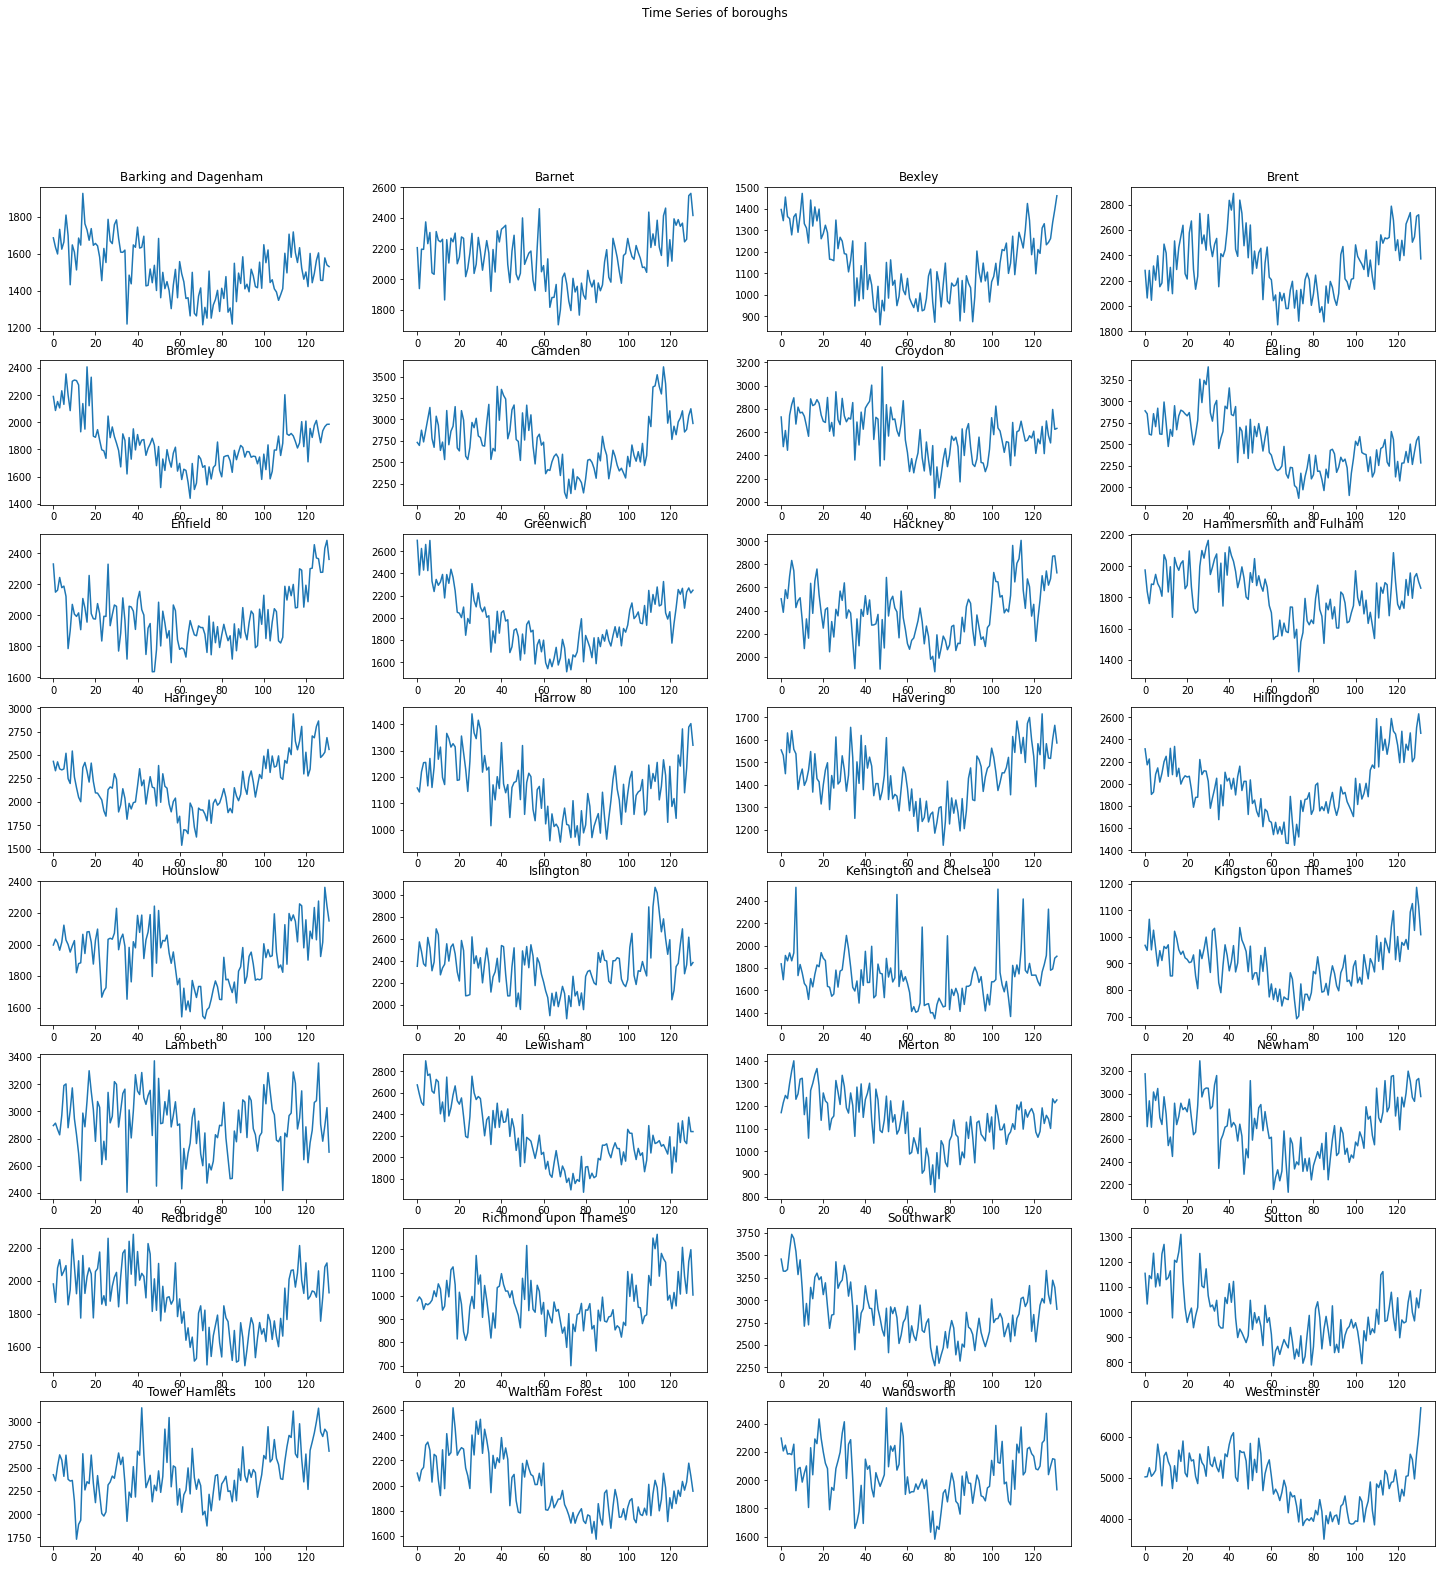

In [78]:
fig, axs = plt.subplots(8,4,figsize=(25,25))
fig.suptitle('Time Series of boroughs')
for i in range(8):
    for j in range(4):
        if i*4+j+1>len(df1.columns): # pass the others that we can't fill
            continue
        axs[i, j].plot(df1[df1.columns[i*4+j+1]].values)
        axs[i, j].set_title(df1.columns[i*4+j+1])
plt.show()

In [79]:
df2 = df1.drop(['Date'],axis=1)

In [80]:
for c in df2.columns.values:
    scaler = MinMaxScaler()
    df2[c] = scaler.fit_transform(df2[c].values.reshape(-1, 1))

In [81]:
df2 = df2.T
df2.head(3)

DateTime,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,2010-11-01,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,...,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
Borough,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham,0.661495,0.590973,0.538787,0.726375,0.575458,0.630465,0.834979,0.678420,0.304654,0.607898,0.552891,0.417489,0.660085,0.606488,1.000000,0.768688,0.722144,0.643159,0.732017,0.605078,0.619182,0.600846,0.514810,0.335684,0.581100,0.473907,0.802539,0.637518,0.617772,0.761636,0.798307,0.658674,0.552891,0.551481,0.568406,0.005642,0.377997,0.311707,0.607898,0.589563,...,0.308886,0.251058,0.423131,0.372355,0.290550,0.282087,0.476728,0.277856,0.609309,0.472496,0.569817,0.321580,0.342736,0.273625,0.249647,0.186178,0.228491,0.275035,0.544429,0.394922,0.689704,0.513399,0.706629,0.548660,0.473907,0.586742,0.431594,0.346968,0.401975,0.290550,0.543018,0.320169,0.390691,0.490832,0.547250,0.338505,0.337094,0.509168,0.455571,0.442877
Barnet,0.586931,0.275379,0.575263,0.574096,0.782964,0.617270,0.702450,0.395566,0.383897,0.709452,0.642940,0.631272,0.651109,0.189032,0.647608,0.470245,0.659277,0.631272,0.697783,0.464411,0.514586,0.668611,0.658110,0.366394,0.430572,0.544924,0.695449,0.390898,0.460910,0.665111,0.558926,0.415403,0.528588,0.640607,0.546091,0.254376,0.572929,0.401400,0.715286,0.630105,...,0.324387,0.658110,0.589265,0.512252,0.406068,0.316219,0.527421,0.542590,0.656943,0.577596,0.519253,0.498250,0.603267,0.549592,0.505251,0.436406,0.438740,0.399067,0.857643,0.588098,0.691949,0.604434,0.795799,0.591599,0.527421,0.829638,0.887981,0.445741,0.647608,0.484247,0.806301,0.757293,0.800467,0.749125,0.773629,0.631272,0.651109,0.982497,1.000000,0.831972
Bexley,0.877250,0.792144,0.972177,0.823241,0.808511,0.684124,0.821604,0.844517,0.703764,0.834697,1.000000,0.769231,0.736498,0.621931,0.949264,0.751227,0.896890,0.790507,0.880524,0.654664,0.693944,0.757774,0.700491,0.499182,0.495908,0.487725,0.797054,0.579378,0.666121,0.636661,0.541735,0.536825,0.402619,0.489362,0.638298,0.142390,0.356792,0.183306,0.450082,0.198036,...,0.214403,0.561375,0.404255,0.325696,0.469722,0.333879,0.400982,0.173486,0.327332,0.368249,0.468085,0.301146,0.471358,0.572831,0.564648,0.621931,0.391162,0.469722,0.674304,0.381342,0.543372,0.703764,0.648118,0.584288,0.721768,0.923077,0.793781,0.533552,0.657938,0.387889,0.572831,0.543372,0.736498,0.769231,0.608838,0.626841,0.656301,0.779051,0.875614,0.981997


In [82]:
cluster_count = math.ceil(math.sqrt(len(df2))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

labels = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw").fit_predict(df2)
labels

array([1, 2, 2, 3, 1, 3, 5, 1, 2, 1, 3, 5, 2, 2, 2, 2, 3, 3, 4, 3, 3, 1,
       5, 2, 1, 3, 1, 1, 3, 1, 0, 2])

In [83]:
df3 = np.array(df2)

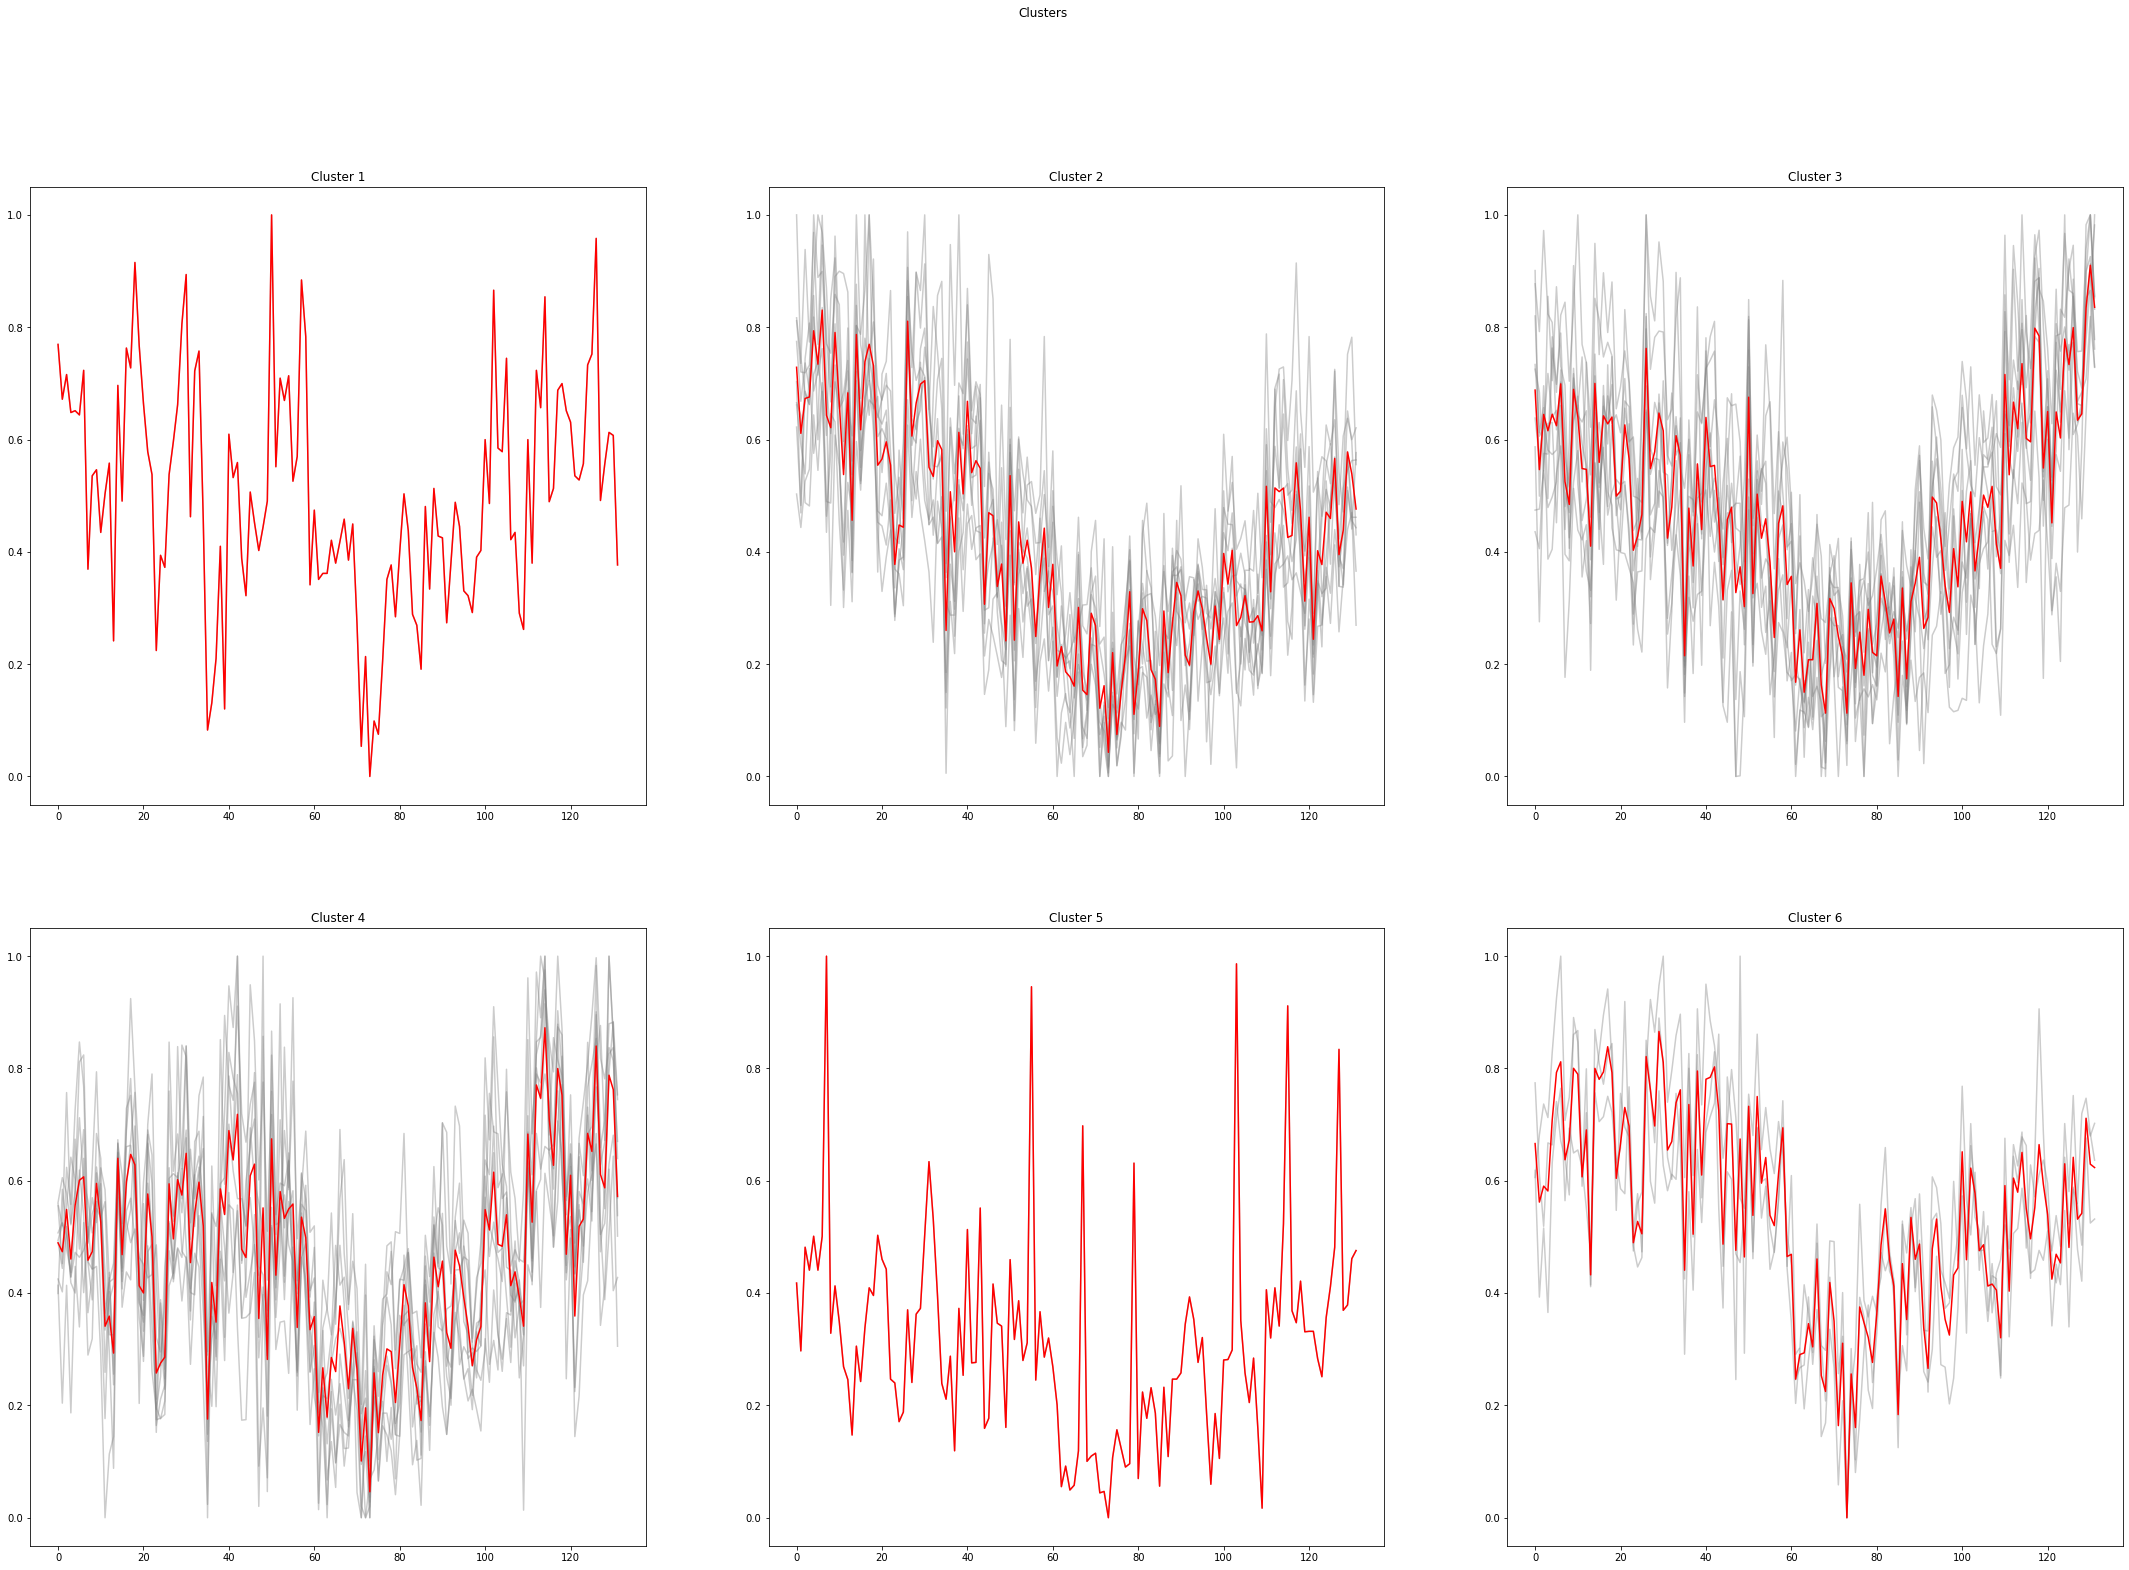

In [84]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(2,plot_count,figsize=(37.5,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in range(6):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(df3[i],c="gray",alpha=0.4)
                cluster.append(df3[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(label + 1))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

In [85]:
df2['clustering'] = labels

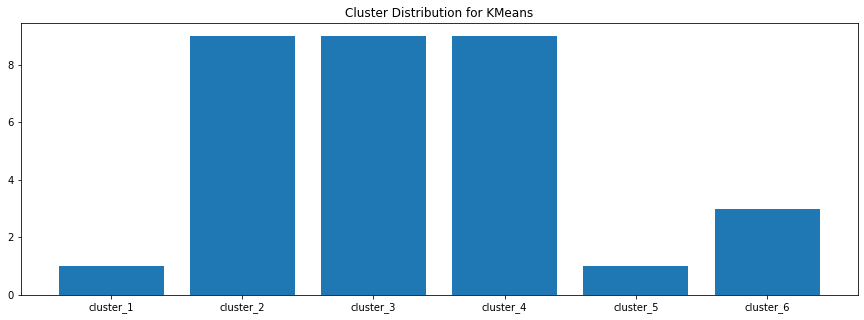

In [86]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i + 1) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [87]:
import os
!pip install geopandas
import geopandas as gpd
import matplotlib.cm as cm

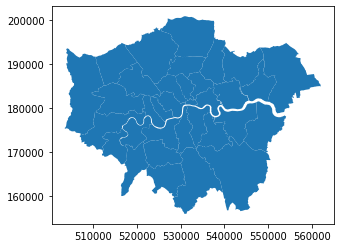

In [88]:
path = 'https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true'
map_bor = gpd.read_file(path)
map_bor.plot()

In [89]:
tsClusteringResult = pd.DataFrame(df2['clustering'],dtype="category")
tsClusteringResult.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Barking and Dagenham to Westminster
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   clustering  32 non-null     category
dtypes: category(1)
memory usage: 1.7+ KB


In [90]:
map1 = map_bor.merge(tsClusteringResult,left_on='NAME', right_on='Borough')
map1

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,clustering
0,Kingston upon Thames,E09000021,3726.117,0.000,F,"MULTIPOLYGON (((516401.600 160201.800, 516407....",3
1,Croydon,E09000008,8649.441,0.000,F,"MULTIPOLYGON (((535009.200 159504.700, 535005....",5
2,Bromley,E09000006,15013.487,0.000,F,"MULTIPOLYGON (((540373.600 157530.400, 540361....",1
3,Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((521975.800 178100.000, 521967....",3
4,Ealing,E09000009,5554.428,0.000,F,"MULTIPOLYGON (((510253.500 182881.600, 510249....",1
5,Havering,E09000016,11445.735,210.763,F,"MULTIPOLYGON (((549893.900 181459.800, 549894....",2
6,Hillingdon,E09000017,11570.063,0.000,F,"MULTIPOLYGON (((510599.800 191689.500, 510615....",2
7,Harrow,E09000015,5046.330,0.000,F,"MULTIPOLYGON (((510599.800 191689.500, 510660....",2
8,Brent,E09000005,4323.270,0.000,F,"MULTIPOLYGON (((525201.000 182512.600, 525181....",3
9,Barnet,E09000003,8674.837,0.000,F,"MULTIPOLYGON (((524579.900 198355.200, 524594....",2


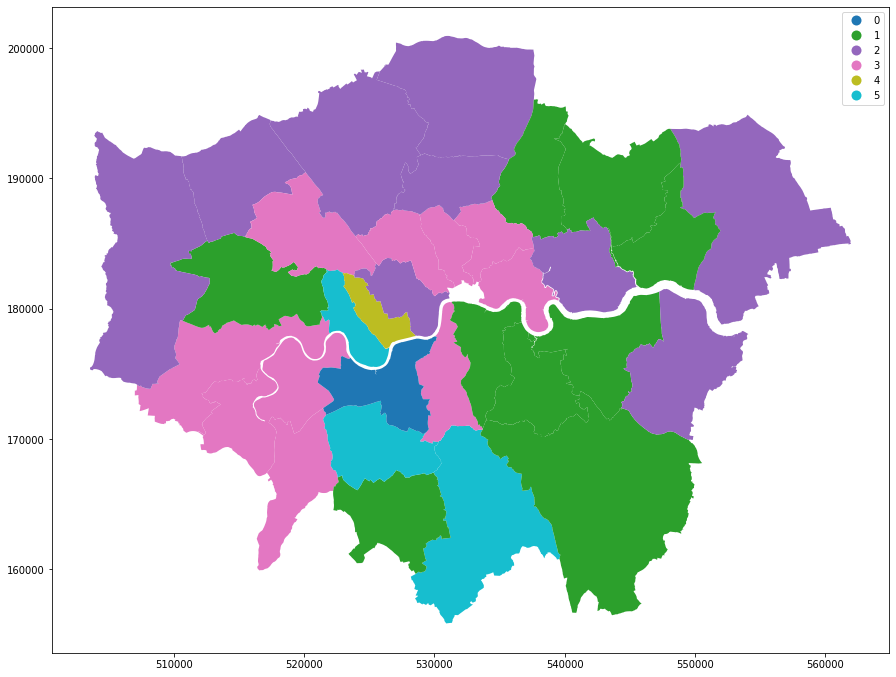

In [91]:
fig, ax = plt.subplots(1,1,figsize=(15,15),)
map1.plot(column='clustering',ax=ax, legend=True)

### 4.2 Clustering of the composition of crime types

In [92]:
df5 = df.drop(['Minor Category'],axis=1)
df5

,Borough,Major Category,200801,200802,200803,200804,200805,200806,200807,200808,200809,200810,200811,200812,200901,200902,200903,200904,200905,200906,200907,200908,200909,200910,200911,200912,201001,201002,201003,201004,201005,201006,201007,201008,201009,201010,201011,201012,201101,201102,...,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
0,Barking and Dagenham,Burglary,82,71,87,74,74,103,113,96,95,107,120,148,180,149,155,112,135,119,149,124,159,180,184,157,169,161,123,118,102,124,137,153,136,116,140,105,165,122,...,77,105,111,119,103,86,73,47,77,63,55,54,49,60,73,100,118,124,93,101,129,71,95,83,81,122,88,124,143,134,122,75,93,77,94,84,99,94,106,163
1,Barking and Dagenham,Burglary,59,68,56,53,57,39,44,37,52,65,52,67,51,67,64,80,69,51,56,49,58,39,51,55,53,47,49,49,58,59,47,46,51,52,62,49,50,51,...,50,34,36,32,44,53,32,42,42,47,32,33,45,40,24,19,40,78,67,53,68,57,72,47,42,47,53,49,67,48,61,65,39,52,40,36,50,61,60,50
2,Barking and Dagenham,Criminal Damage,79,52,55,73,63,80,73,75,59,68,71,55,70,74,56,61,65,69,62,59,58,44,56,48,50,67,39,63,58,55,67,65,39,59,51,48,59,49,...,28,28,36,38,36,39,50,36,58,30,48,38,31,29,32,26,28,31,36,31,32,46,48,49,28,35,32,28,34,23,30,29,32,29,21,29,23,35,21,15
3,Barking and Dagenham,Criminal Damage,142,138,118,158,126,96,116,123,103,102,106,111,115,107,173,134,151,97,103,80,72,88,92,66,95,69,114,97,81,114,80,78,80,93,80,56,71,76,...,68,65,80,105,75,83,73,61,81,73,69,68,61,69,67,59,65,62,61,61,71,59,66,77,72,63,48,57,60,51,53,64,64,67,69,42,38,42,47,33
4,Barking and Dagenham,Criminal Damage,20,19,20,23,16,12,17,18,14,14,14,9,22,21,16,24,19,12,9,21,7,15,12,12,12,18,13,17,16,14,27,16,10,12,21,9,14,10,...,10,9,16,10,13,10,21,13,13,18,15,16,11,12,16,8,10,6,13,9,7,12,6,8,7,12,11,10,10,5,6,9,8,8,7,7,11,5,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,Westminster,Violence Against the Person,207,191,187,185,233,223,259,234,228,233,221,204,203,205,250,206,257,218,267,221,231,232,227,191,220,181,234,195,211,248,281,205,198,183,182,137,176,176,...,291,242,288,293,229,235,249,261,275,300,404,339,342,323,296,297,265,292,360,346,373,421,429,411,345,389,387,341,354,344,346,388,415,428,446,389,414,391,388,386
1052,Westminster,Violence Against the Person,0,1,2,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,4,2,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1053,Westminster,Violence Against the Person,27,20,22,21,24,37,39,38,17,32,28,33,29,22,23,20,20,23,18,16,25,23,16,15,17,21,27,16,14,15,15,26,15,16,18,10,23,16,...,26,23,16,6,12,4,26,18,23,25,21,44,19,34,22,22,26,21,25,34,35,21,24,66,23,42,23,20,34,24,23,38,29,29,33,46,28,30,24,41
1054,Westminster,Violence Against the Person,38,25,32,24,22,42,61,50,42,35,45,40,39,25,33,38,44,31,38,37,36,32,47,39,30,45,40,41,34,58,37,32,34,51,31,41,39,40,...,33,23,47,40,52,24,52,57,48,47,53,47,59,39,59,49,117,90,104,51,55,41,47,52,42,71,104,59,85,67,61,57,88,70,79,83,36,43,37,38


In [93]:
df6 = df5.groupby(['Borough','Major Category'], as_index=False).sum()
df6['median_cases'] = df6.median(axis=1)
df7 = df6[['Borough','Major Category','median_cases']]
df7

,Borough,Major Category,median_cases
0,Barking and Dagenham,Burglary,167.0
1,Barking and Dagenham,Criminal Damage,158.5
2,Barking and Dagenham,Drugs,88.5
3,Barking and Dagenham,Fraud or Forgery,5.0
4,Barking and Dagenham,Other Notifiable Offences,28.0
...,...,...,...
283,Westminster,Other Notifiable Offences,69.0
284,Westminster,Robbery,168.5
285,Westminster,Sexual Offences,55.0
286,Westminster,Theft and Handling,2841.5


In [94]:
df8 = df7.pivot(index='Borough', columns='Major Category', values='median_cases')
df8

Major Category,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person
Borough,,,,,,,,,
Barking and Dagenham,167.0,158.5,88.5,5.0,28.0,57.0,27.0,483.0,430.5
Barnet,341.0,183.5,82.5,8.5,29.0,66.0,30.0,838.0,431.5
Bexley,136.0,144.0,65.0,2.0,19.0,22.0,19.0,375.5,298.5
Brent,276.5,190.0,243.5,7.0,38.5,123.0,34.0,696.5,623.0
Bromley,253.5,197.5,80.5,5.5,26.0,45.0,27.0,657.5,466.5
Camden,271.5,159.5,168.0,7.5,37.0,90.5,34.0,1330.0,509.5
Croydon,303.0,273.0,175.0,6.5,44.0,114.0,46.5,835.0,619.0
Ealing,273.5,219.5,155.0,8.5,43.0,83.5,37.0,864.5,662.0
Enfield,289.0,191.0,112.5,7.5,34.0,87.0,33.0,693.5,409.0


In [95]:
df8.corr().style.background_gradient(cmap='Blues')

Major Category,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person
Major Category,,,,,,,,,
Burglary,1.000000,0.785665,0.609422,0.652341,0.703494,0.718768,0.748395,0.539996,0.730704
Criminal Damage,0.785665,1.000000,0.587378,0.481395,0.767959,0.706421,0.841945,0.380797,0.864112
Drugs,0.609422,0.587378,1.000000,0.750881,0.905406,0.882350,0.840473,0.810311,0.837559
Fraud or Forgery,0.652341,0.481395,0.750881,1.000000,0.778389,0.719444,0.721539,0.838640,0.686497
Other Notifiable Offences,0.703494,0.767959,0.905406,0.778389,1.000000,0.866813,0.929654,0.815554,0.932117
Robbery,0.718768,0.706421,0.882350,0.719444,0.866813,1.000000,0.924713,0.693808,0.875760
Sexual Offences,0.748395,0.841945,0.840473,0.721539,0.929654,0.924713,1.000000,0.701651,0.937713
Theft and Handling,0.539996,0.380797,0.810311,0.838640,0.815554,0.693808,0.701651,1.000000,0.641178
Violence Against the Person,0.730704,0.864112,0.837559,0.686497,0.932117,0.875760,0.937713,0.641178,1.000000


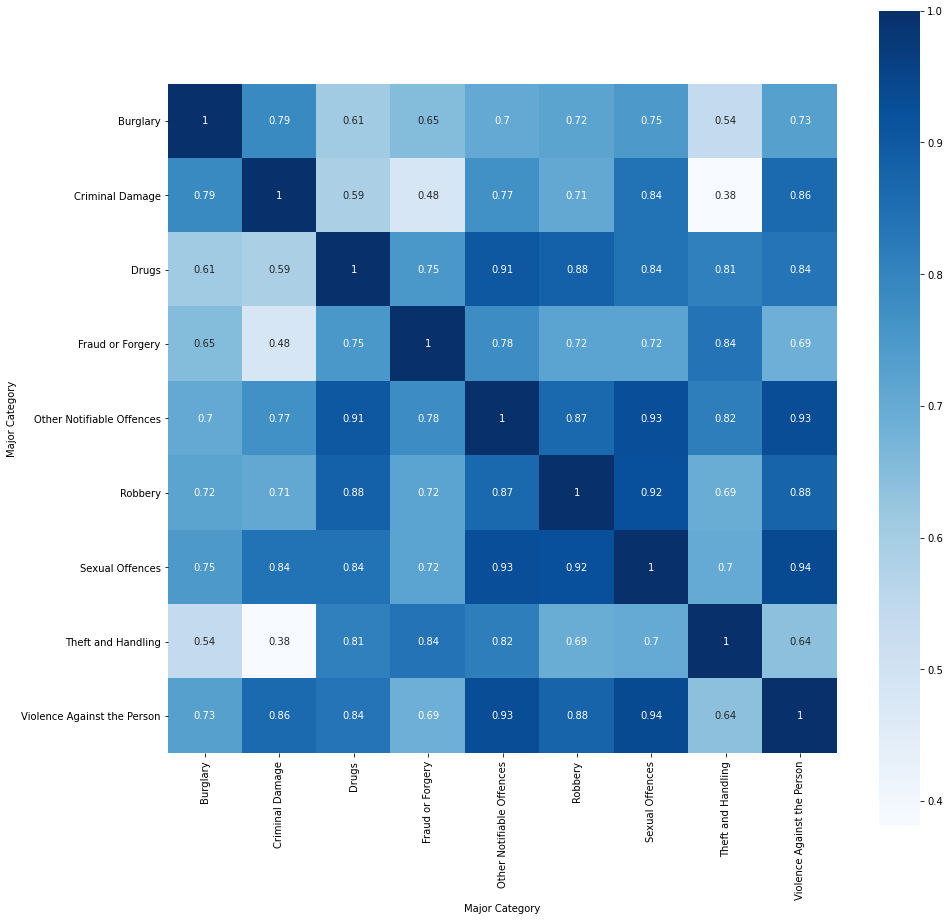

In [96]:
plt.subplots(figsize=(15, 15))
sns.heatmap(df8.corr(), annot=True, vmax=1, square=True, cmap="Blues")
plt.show()

In [97]:
from scipy.cluster import hierarchy

for c in df8.columns.values:
    scaler = MinMaxScaler()
    df8[c] = scaler.fit_transform(df8[c].values.reshape(-1, 1))

df8.head(5)

Major Category,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person
Borough,,,,,,,,,
Barking and Dagenham,0.292683,0.370879,0.162479,0.24,0.267857,0.273616,0.300,0.054141,0.422422
Barnet,1.000000,0.508242,0.142379,0.52,0.285714,0.332248,0.375,0.196511,0.424215
Bexley,0.166667,0.291209,0.083752,0.00,0.107143,0.045603,0.100,0.011029,0.185650
Brent,0.737805,0.543956,0.681742,0.40,0.455357,0.703583,0.475,0.139763,0.767713
Bromley,0.644309,0.585165,0.135678,0.28,0.232143,0.195440,0.300,0.124123,0.486996


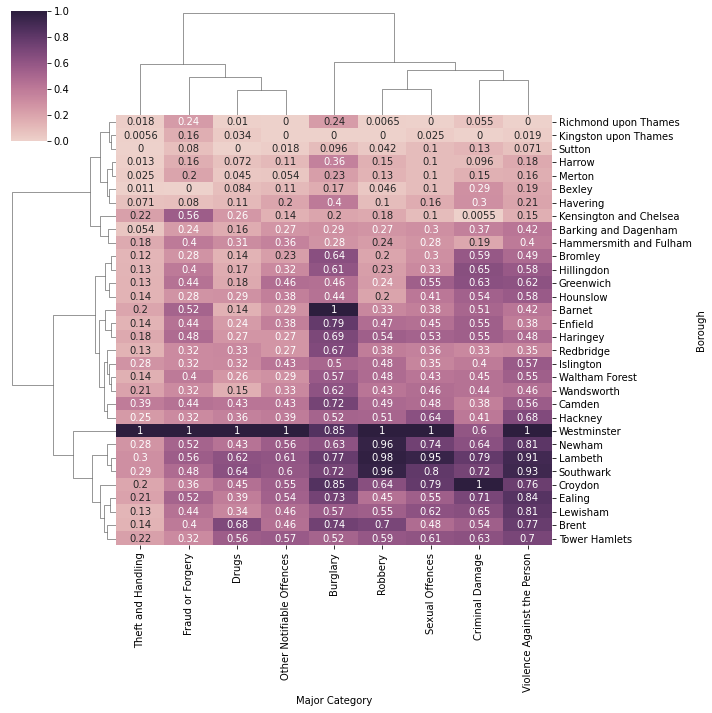

In [98]:
sns.clustermap(df8,method ='ward',metric='euclidean', cmap=sns.cubehelix_palette(as_cmap=True), annot=True)

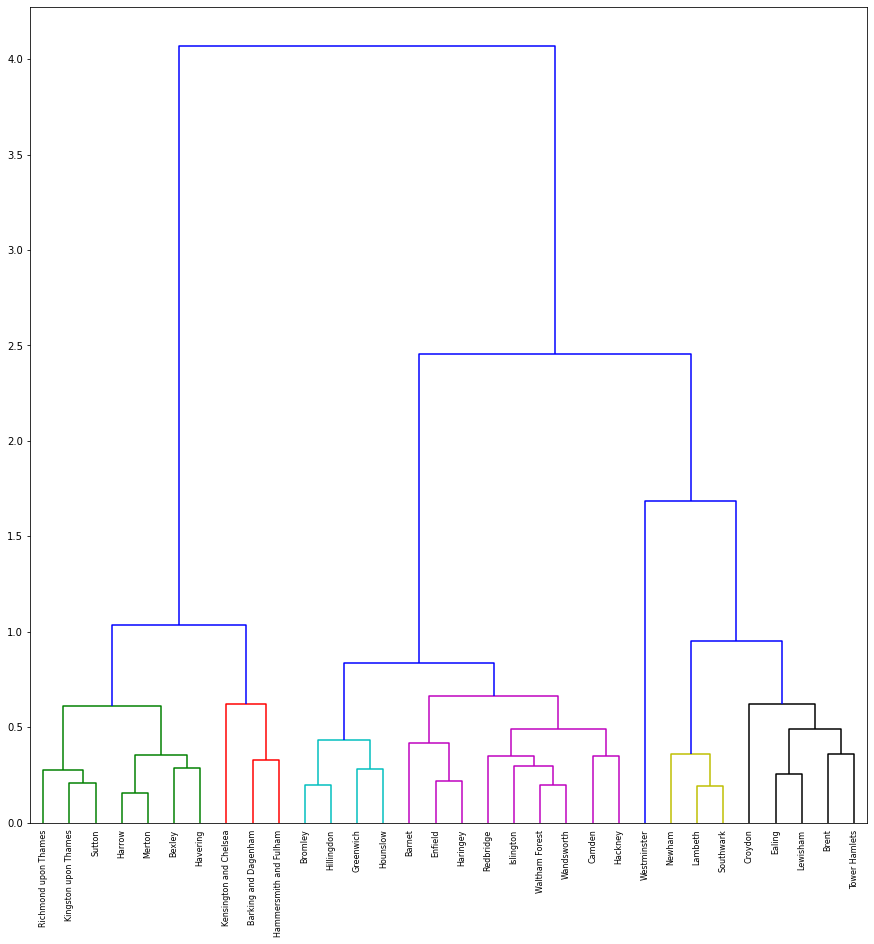

In [99]:
Z = hierarchy.linkage(df8, method ='ward',metric='euclidean')

plt.subplots(figsize=(15, 15))
hierarchy.dendrogram(Z,labels = df8.index,leaf_rotation=90,color_threshold=0.8)
plt.show()

In [100]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(df8)
y_hc

array([1, 0, 4, 2, 6, 0, 2, 2, 0, 6, 0, 1, 0, 4, 4, 6, 6, 0, 1, 4, 5, 2,
       4, 5, 0, 4, 5, 4, 2, 0, 0, 3])

In [101]:
df9 = df8
df9['clustering']=y_hc
df9.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Barking and Dagenham to Westminster
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Burglary                     32 non-null     float64
 1   Criminal Damage              32 non-null     float64
 2   Drugs                        32 non-null     float64
 3   Fraud or Forgery             32 non-null     float64
 4   Other Notifiable Offences    32 non-null     float64
 5   Robbery                      32 non-null     float64
 6   Sexual Offences              32 non-null     float64
 7   Theft and Handling           32 non-null     float64
 8   Violence Against the Person  32 non-null     float64
 9   clustering                   32 non-null     int64  
dtypes: float64(9), int64(1)
memory usage: 2.8+ KB


In [102]:

hClusteringResult = pd.DataFrame(df8['clustering'],dtype="category")
hClusteringResult.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Barking and Dagenham to Westminster
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   clustering  32 non-null     category
dtypes: category(1)
memory usage: 664.0+ bytes


In [103]:
map2 = map_bor.merge(hClusteringResult,left_on='NAME', right_on='Borough')

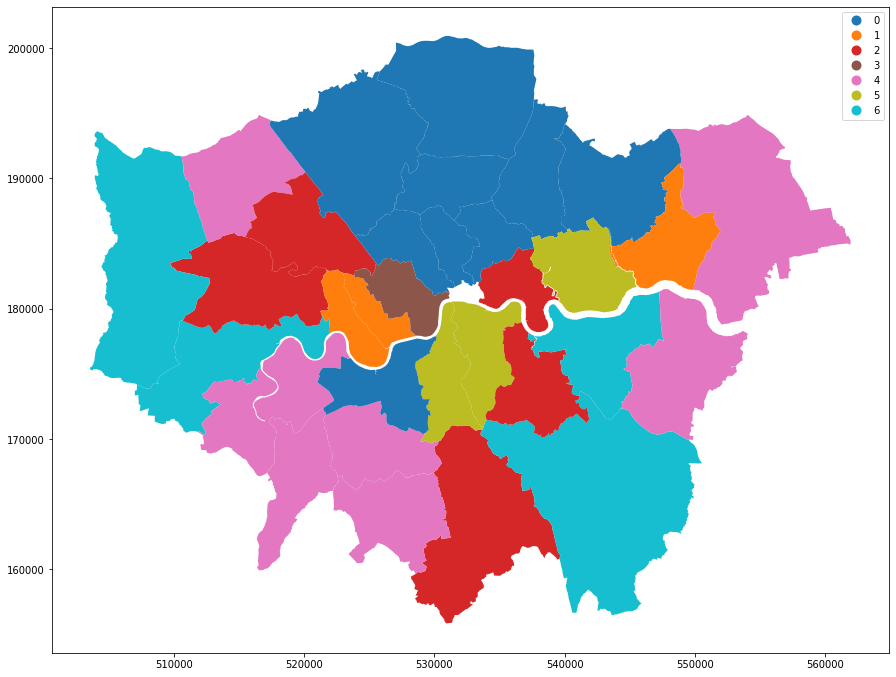

In [104]:
fig, ax = plt.subplots(1,1,figsize=(15,15),)
map2.plot(column='clustering',ax=ax, legend=True)

### 4.3 Time Series Prediction

In [105]:
df4 = df1.drop(['Date'],axis=1)
df4['Total'] = df1.sum(axis=1)
df4 = pd.DataFrame(df4['Total'])
df4.info

<bound method DataFrame.info of             Total
DateTime         
2008-01-01  71564
2008-02-01  68562
2008-03-01  70939
2008-04-01  69394
2008-05-01  72349
...           ...
2018-08-01  69171
2018-09-01  68759
2018-10-01  73981
2018-11-01  74249
2018-12-01  71542

[132 rows x 1 columns]>

In [106]:
for c in df4.columns.values:
    scaler = MinMaxScaler()
    df4[c] = scaler.fit_transform(df4[c].values.reshape(-1, 1))

In [107]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2008-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Total   132 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


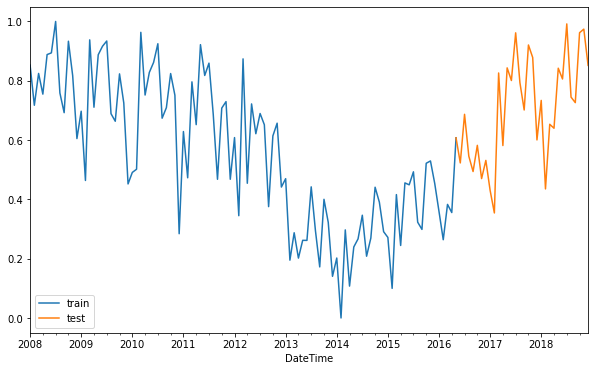

In [108]:
model =  df4['Total']
train = model.iloc[:101]
test = model.iloc[100:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [109]:
predict_days = 1
X_train = train[:-predict_days]
y_train = train[predict_days:]
 
X_test = test[:-predict_days]
y_test = test[predict_days:]


In [110]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [111]:
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
100/100 [==============================] - 0s 915us/step - loss: 0.2519
Epoch 2/100
100/100 [==============================] - 0s 760us/step - loss: 0.0529
Epoch 3/100
100/100 [==============================] - 0s 840us/step - loss: 0.0387
Epoch 4/100
100/100 [==============================] - 0s 804us/step - loss: 0.0387
Epoch 5/100
100/100 [==============================] - 0s 843us/step - loss: 0.0387
Epoch 6/100
100/100 [==============================] - 0s 919us/step - loss: 0.0385
Epoch 7/100
100/100 [==============================] - 0s 896us/step - loss: 0.0383
Epoch 8/100
100/100 [==============================] - 0s 874us/step - loss: 0.0381
Epoch 9/100
100/100 [==============================] - 0s 846us/step - loss: 0.0379
Epoch 10/100
100/100 [==============================] - 0s 798us/step - loss: 0.0378
Epoch 11/100
100/100 [==============================] - 0s 913us/step - loss: 0.0376
Epoch 12/100
100/100 [==============================] - 0s 802us/step - lo

In [112]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.436
The R2 score on the Test set is:	-0.248


In [113]:

y_test.index = pd.to_datetime(y_test.index)


In [114]:
data = y_pred_test_nn
data_list = np.array(data).flatten().tolist()

ser = pd.Series(data_list)
ser.index = pd.to_datetime(y_test.index)
y_pred_test_nn = ser

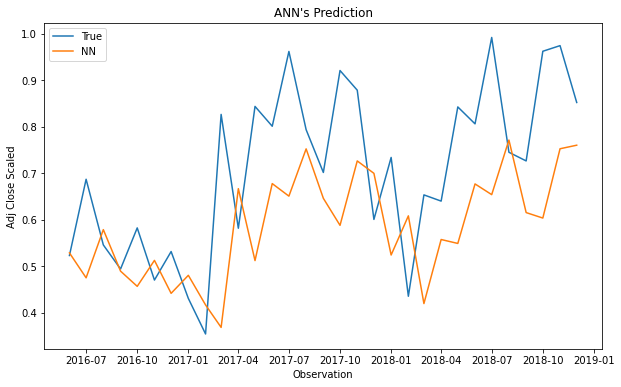

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show()

In [116]:
anne = train.values.reshape(101,1)
anne

array([[0.85292391],
       [0.71736284],
       [0.82470084],
       [0.75493339],
       [0.88837209],
       [0.89406186],
       [1.        ],
       [0.75881689],
       [0.69239106],
       [0.93339354],
       [0.81756604],
       [0.60505758],
       [0.69731316],
       [0.46376157],
       [0.93795439],
       [0.71076993],
       [0.88769474],
       [0.91632423],
       [0.93411605],
       [0.68895913],
       [0.66349063],
       [0.82325581],
       [0.72503951],
       [0.45206593],
       [0.49085572],
       [0.50164823],
       [0.96333258],
       [0.75190788],
       [0.82826823],
       [0.86195529],
       [0.92490404],
       [0.67378641],
       [0.7093249 ],
       [0.82433958],
       [0.75123053],
       [0.2841725 ],
       [0.62876496],
       [0.4727478 ],
       [0.79629713],
       [0.65202077],
       [0.92178821],
       [0.8179273 ],
       [0.85942651],
       [0.68706254],
       [0.46773538],
       [0.70787988],
       [0.72964552],
       [0.467

In [117]:
test

DateTime
2016-05-01    0.607722
2016-06-01    0.522917
2016-07-01    0.686837
2016-08-01    0.545631
2016-09-01    0.493881
2016-10-01    0.582253
2016-11-01    0.470084
2016-12-01    0.531407
2017-01-01    0.430616
2017-02-01    0.354166
2017-03-01    0.826281
2017-04-01    0.581531
2017-05-01    0.843486
2017-06-01    0.800858
2017-07-01    0.961662
2017-08-01    0.793452
2017-09-01    0.701468
2017-10-01    0.920659
2017-11-01    0.878392
2017-12-01    0.600497
2018-01-01    0.733755
2018-02-01    0.435268
2018-03-01    0.653240
2018-04-01    0.639874
2018-05-01    0.842357
2018-06-01    0.805961
2018-07-01    0.991736
2018-08-01    0.744863
2018-09-01    0.726259
2018-10-01    0.962068
2018-11-01    0.974170
2018-12-01    0.851930
Name: Total, dtype: float64

In [118]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [119]:
# reshape into X=t and Y=t+1
look_back = 1

trainX, trainY = create_dataset(train.values.reshape(101,1), look_back)
testX, testY = create_dataset(test.values.reshape(32,1), look_back)

In [120]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [121]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(7, input_shape=(1, look_back),activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
99/99 [==============================] - 1s 1ms/step - loss: 0.3935
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.2670
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1632
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0942
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0582
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0437
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0388
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0371
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0365
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0362
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0360
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0358
Epoch 13/100
99/99 [=================

In [122]:

y_pred_test_lstm = model.predict(testX)
y_train_pred_lstm = model.predict(trainX)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(trainY, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(testY, y_pred_test_lstm)))


The R2 score on the Train set is:	0.490
The R2 score on the Test set is:	-0.033


In [123]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = model.evaluate(testX, testY, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)


30/30 [==============================] - 0s 931us/step - loss: 0.0328
NN: 0.039264
LSTM: 0.032850


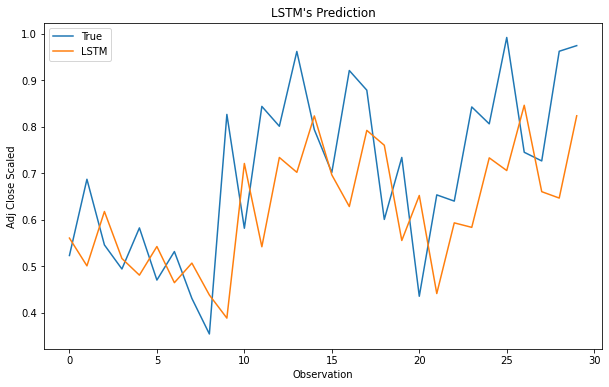

In [124]:
plt.figure(figsize=(10, 6))
plt.plot(testY, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();
